In [1]:
import pandas as pd
import numpy as np
import glob
from itertools import combinations

%load_ext autoreload
%autoreload 1

%aimport modules
from modules import qubo_from_data
from modules import process_qubo_df
from modules import reduce_higher_order_terms
from modules import qubo_matrix_from_df
from modules import print_qubo_matrix
from modules import read_spot_file

# Benchmarking of different encodings and higher order terms reduction methods for a _QUBO_ problem

In [2]:
# get the list of all files in the data directiory
data_dir = 'data/'
dir_list = glob.glob(data_dir+'*.spot')

In [3]:
# create file dataframe
file_df = pd.DataFrame({'file_name': pd.Series(dtype='string'),
                        'n_requests': pd.Series(dtype='int')})

In [4]:
for i, file_path in enumerate(dir_list):
    file_name = file_path.split('/')[-1]
    n_requests = int(file_name.removesuffix('.spot'))
    file_df.loc[i] = list([file_name, n_requests])

In [5]:
file_df = file_df.sort_values(by=['n_requests'], ascending=True)

In [90]:
file_name = '15.spot'
encoding = 'standard'
ho_method = 'boros'

# read spot file
photo_req_df, constraints_df = read_spot_file(data_dir, file_name)

# encode photo requests and constraints into a binary optimization problem
qubo_df = qubo_from_data(photo_req_df, constraints_df, encoding)

# preprocess the binary df (group by duplicates, convert indexes to variables)
qubo_df_, key_to_qubo_dict = process_qubo_df(qubo_df)

n_ho_terms = len(qubo_df_[qubo_df_['rank']>2])
ho_terms = np.array(qubo_df_[qubo_df_['rank']>2]['rank'])

# extract number of original variables (before ho reduction)
n_original_variables = len(key_to_qubo_dict)

# reduce higher order terms
qubo_df_, key_to_qubo_dict = reduce_higher_order_terms(qubo_df_, key_to_qubo_dict, ho_method)

# extract the numebr of ancillary variables 
n_ancillary_variables = len(key_to_qubo_dict) - n_original_variables

In [6]:
from tqdm import tqdm

In [7]:
# create benchmark dataframe
benchmark_df = pd.DataFrame({'file_name':  pd.Series(dtype='string'),
                             'n_requests': pd.Series(dtype='int'),
                             'encoding':   pd.Series(dtype='string'),
                             'ho_method':  pd.Series(dtype='string'),
                             'n_ho_terms': pd.Series(dtype='int'),
                             'ho_terms':   pd.Series(dtype='object'),
                             'n_original_variables': pd.Series(dtype='int'),
                             'n_ancillary_variables': pd.Series(dtype='int')})

In [8]:
# benchmark df index
k=0

# sweeping variables
encodings = ['standard', 'dense']
ho_methods = ['boros', 'ishikawa']

for file_name in tqdm(file_df['file_name'][:-2]):
    for encoding in encodings:
        for ho_method in ho_methods:
            #print(f'processing file {file_name} with encoding {encoding} and ho_method {ho_method}')
            # read spot file
            photo_req_df, constraints_df = read_spot_file(data_dir, file_name)

            # encode photo requests and constraints into a binary optimization problem
            qubo_df = qubo_from_data(photo_req_df, constraints_df, encoding)

            # preprocess the binary df (group by duplicates, convert indexes to variables)
            qubo_df_, key_to_qubo_dict = process_qubo_df(qubo_df)
            
            # save ho_terms specifics
            n_ho_terms = len(qubo_df_[qubo_df_['rank']>2])
            ho_terms = np.array(qubo_df_[qubo_df_['rank']>2]['rank'])

            # extract number of original variables (before ho reduction)
            n_original_variables = len(key_to_qubo_dict)

            # reduce higher order terms
            qubo_df_, key_to_qubo_dict = reduce_higher_order_terms(qubo_df_, key_to_qubo_dict, ho_method)

            # extract the numebr of ancillary variables 
            n_ancillary_variables = len(key_to_qubo_dict) - n_original_variables

            # add to benchmark df
            n_requests = int(file_name.removesuffix('.spot'))
            benchmark_df.loc[k] = list([file_name, n_requests, encoding, ho_method, n_ho_terms, ho_terms, n_original_variables, n_ancillary_variables])

            k = k + 1

100%|██████████| 14/14 [54:17<00:00, 232.65s/it]


In [9]:
benchmark_df['n_requests'] = benchmark_df['file_name'].apply(lambda x: int(x.removesuffix('.spot')))
# add total number of variables column
benchmark_df['n_total_variables'] = benchmark_df['n_original_variables'] + benchmark_df['n_ancillary_variables']

In [10]:
benchmark_df.head()

,file_name,n_requests,encoding,ho_method,n_ho_terms,ho_terms,n_original_variables,n_ancillary_variables,n_total_variables
0,3.spot,3,standard,boros,2,"[3, 3]",8,2,10
1,3.spot,3,standard,ishikawa,2,"[3, 3]",8,2,10
2,3.spot,3,dense,boros,20,"[6, 5, 5, 4, 5, 4, 4, 3, 3, 4, 4, 5, 4, 5, 5, ...",6,14,20
3,3.spot,3,dense,ishikawa,20,"[6, 5, 5, 4, 5, 4, 4, 3, 3, 4, 4, 5, 4, 5, 5, ...",6,26,32
4,8.spot,8,standard,boros,0,[],16,0,16


In [14]:
# save benchmark df
benchmark_df.to_csv('benchmark_df.csv', index=False)

In [13]:
import matplotlib.pyplot as plt

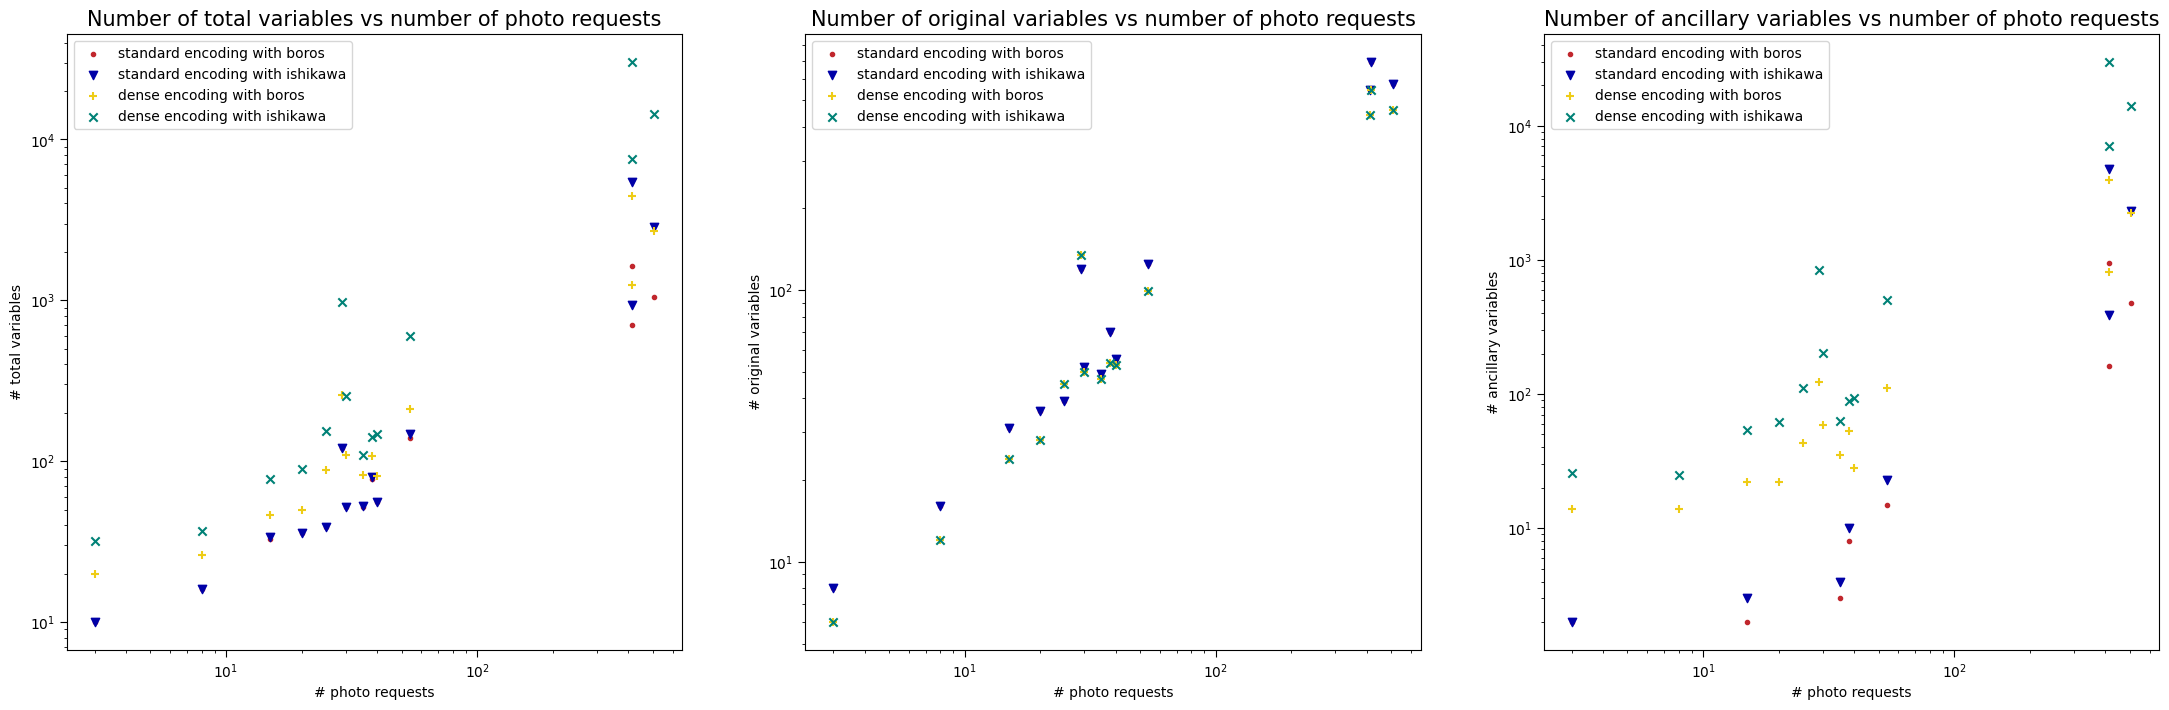

In [15]:
markers = ['.', 'v', '+', 'x']
colors  = ['#c1272d', '#0000a7', '#eecc16', '#008176']

plots = ['total', 'original', 'ancillary']
fig, ax = plt.subplots(1, 3, figsize=(27, 8))

for i, ax_i in enumerate(ax):
    ax_i.set_title(f"Number of {plots[i]} variables vs number of photo requests", fontsize=15)
    ax_i.set_xlabel("# photo requests",     fontsize=10)
    ax_i.set_ylabel(f"# {plots[i]} variables", fontsize=10)
    ax_i.set_xscale('log')
    ax_i.set_yscale('log')
    ax_i.tick_params(axis="both", which="major", labelsize=10, length=5)
    ax_i.grid

    j = 0
    for encoding in encodings:
        for ho_method in ho_methods:
            ax_i.scatter(
                benchmark_df[(benchmark_df['encoding']==encoding) & (benchmark_df['ho_method']==ho_method)]['n_requests'],
                benchmark_df[(benchmark_df['encoding']==encoding) & (benchmark_df['ho_method']==ho_method)][f'n_{plots[i]}_variables'],
                marker = markers[j],
                color = colors[j],
                label = f"{encoding} encoding with {ho_method}"
            )
            j = j+1

    ax_i.legend()

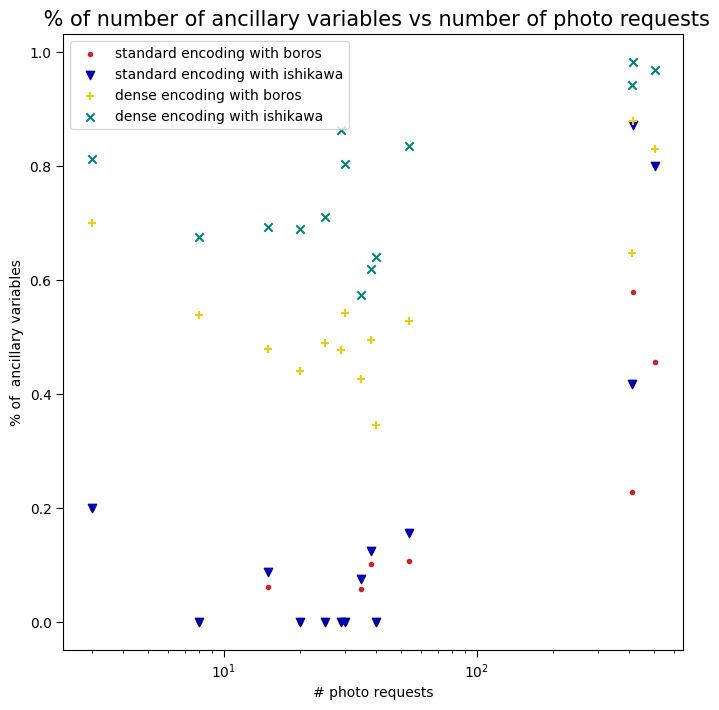

In [16]:
plots = ['total', 'original', 'ancillary']
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_title(f" % of number of ancillary variables vs number of photo requests", fontsize=15)
ax.set_xlabel("# photo requests",     fontsize=10)
ax.set_ylabel(f"% of  ancillary variables", fontsize=10)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.tick_params(axis="both", which="major", labelsize=10, length=5)
ax.grid

j = 0
for encoding in encodings:
    for ho_method in ho_methods:
        ax.scatter(
            benchmark_df[(benchmark_df['encoding']==encoding) & (benchmark_df['ho_method']==ho_method)]['n_requests'],
            benchmark_df[(benchmark_df['encoding']==encoding) & (benchmark_df['ho_method']==ho_method)][f'n_ancillary_variables']/benchmark_df[(benchmark_df['encoding']==encoding) & (benchmark_df['ho_method']==ho_method)][f'n_total_variables'],
            marker = markers[j],
            color = colors[j],
            label = f"{encoding} encoding with {ho_method}"
        )
        j = j+1

ax.legend()

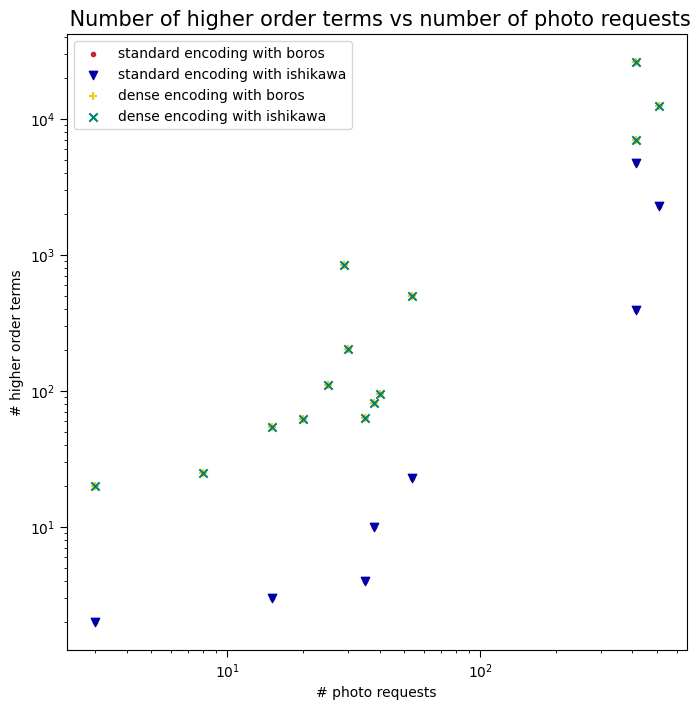

In [18]:
plots = ['total', 'original', 'ancillary']
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_title(f" Number of higher order terms vs number of photo requests", fontsize=15)
ax.set_xlabel("# photo requests",     fontsize=10)
ax.set_ylabel(f"# higher order terms", fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis="both", which="major", labelsize=10, length=5)
ax.grid

j = 0
for encoding in encodings:
    for ho_method in ho_methods:
        ax.scatter(
            benchmark_df[(benchmark_df['encoding']==encoding) & (benchmark_df['ho_method']==ho_method)]['n_requests'],
            benchmark_df[(benchmark_df['encoding']==encoding) & (benchmark_df['ho_method']==ho_method)]['n_ho_terms'],
            marker = markers[j],
            color = colors[j],
            label = f"{encoding} encoding with {ho_method}"
        )
        j = j+1

ax.legend()